In [4]:
using Pkg
Pkg.activate("..")
using Revise
using FUSE
using FUSE.IMAS
using Plots; gr();

  Activating environment at `~/Coding/julia/FUSE/Project.toml`


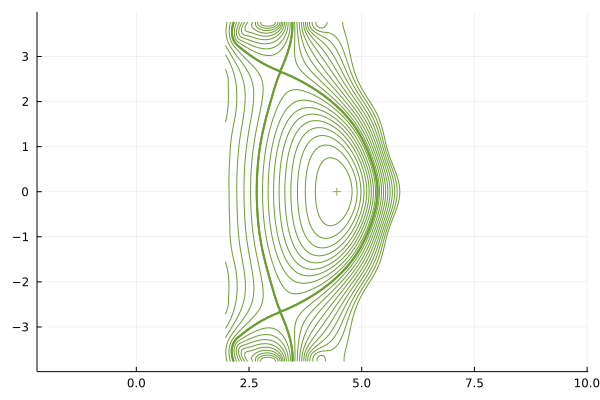

In [53]:
dd=IMAS.json2imas("/Users/meneghini/.julia/dev/FUSE/sample/CAT_eq_ods.json");
plot(dd.equilibrium.time_slice[1])
IMAS.flux_surfaces(dd.equilibrium)

In [79]:
# Initialize layers of radial build explicitly
#
# rb=FUSE.init(IMAS.radial_build(),
#     Bmax_OH=11.0,
#     Bmax_TF=5.3,
#     gap_OH=1.0,
#     OH=0.12,
#     TF=0.37,
#     my_gap=0.5,
#     inner_shield=0.01,
#     inner_blanket=0.22,
#     inner_wall=0.01,
#     vacuum_vessel=1,
#     outer_wall=0.01,
#     outer_blanket=0.22,
#     outer_shield=0.01
# )

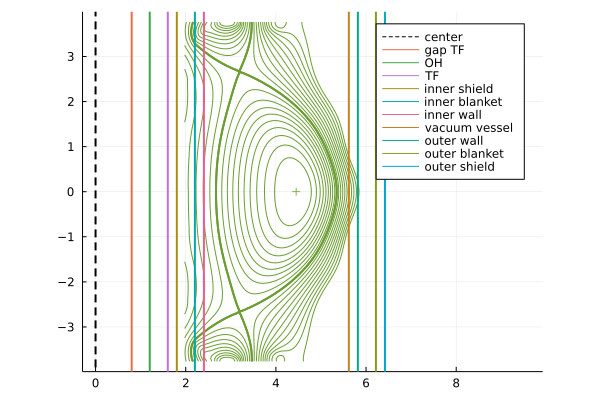

CORE_PROFILES
｜global_quantities
｜｜ejima ➡ 1-element Vector{Float64}
｜time ➡ 1-element Vector{Float64}

DATASET_DESCRIPTION
｜data_entry
｜｜pulse ➡ 307006

EQUILIBRIUM
｜ids_properties
｜｜comment ➡ "  EFITD "
｜time ➡ 1-element Vector{Float64}
｜time_slice
｜｜[1]
｜｜｜boundary
｜｜｜｜elongation ➡ Function
｜｜｜｜elongation_lower ➡ Function
｜｜｜｜elongation_upper ➡ Function
｜｜｜｜geometric_axis
｜｜｜｜｜r ➡ Function
｜｜｜｜｜z ➡ Function
｜｜｜｜minor_radius ➡ Function
｜｜｜｜outline
｜｜｜｜｜r ➡ 91-element Vector{Float64}
｜｜｜｜｜z ➡ 91-element Vector{Float64}
｜｜｜｜squareness_lower_inner ➡ Function
｜｜｜｜squareness_lower_outer ➡ Function
｜｜｜｜squareness_upper_inner ➡ Function
｜｜｜｜squareness_upper_outer ➡ Function
｜｜｜｜triangularity ➡ Function
｜｜｜｜triangularity_lower ➡ Function
｜｜｜｜triangularity_upper ➡ Function
｜｜｜｜x_point
｜｜｜｜｜[1]
｜｜｜｜｜｜r ➡ 3.194865405982973
｜｜｜｜｜｜z ➡ -2.6679803806386997
｜｜｜｜｜[2]
｜｜｜｜｜｜r ➡ 4.449185197594817
｜｜｜｜｜｜z ➡ -0.0012635110785437957
｜｜｜global_quantities
｜｜｜｜beta_normal ➡ 3.5381357677716143
｜｜｜｜beta_pol ➡ 2

In [82]:
# initialize layers of radial build 
FUSE.init(dd.radial_build,dd.equilibrium.time_slice[1],is_nuclear_facility=true)

# plot
plot(dd.equilibrium.time_slice[1])
display(plot!(dd.radial_build))

# 
FUSE.oh_actor(dd, 0.006, ejima=0.4)

#FUSE.stress_calculations(dd)

In [86]:
maximum([0.3,1])

1.0